# 2.2 Using PyTorch to measure the performance with RNN network configurations for MNIST digit classification.

In [1]:
import torch

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
from torchvision import datasets
from torchvision.transforms import ToTensor
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



## Print train_data, test_data and its size

In [13]:
print(train_data )
print(" ")
print(test_data)
print(" ")
print(train_data.data.size())
print(" ")
print(train_data.targets.size())
print(" ")
print(train_data.data[0])

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
 
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()
 
torch.Size([60000, 28, 28])
 
torch.Size([60000])
 
tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0

## Visualize the MNIST dataset

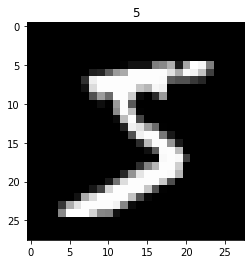

In [14]:
import matplotlib.pyplot as plt
plt.imshow(train_data.data[0], cmap='gray')
plt.title('%i' % train_data.targets[0])
plt.show()

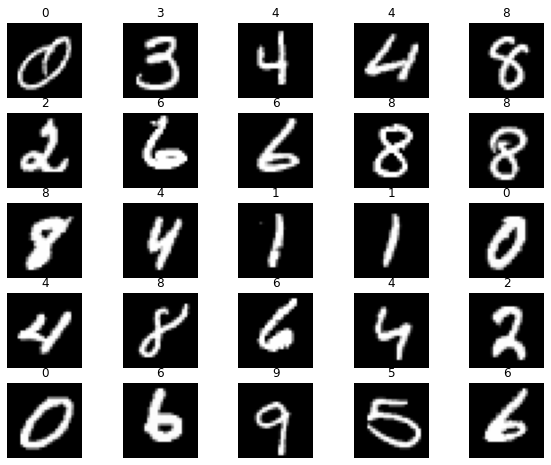

In [15]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Preparing data for training with DataLoaders

In [17]:
from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True, num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=True, num_workers=1),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7fdc61c428e0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7fdc61bf70a0>}

### Define the Recurrent Neural Network model
1. Create a class
2. Add consrtuctor in RNN class
3. Add forward method to the class
4. Set initial hidden state and cell state
5. Pass the input and hidden state into the model


In [18]:
from torch import nn
import torch.nn.functional as F

In [19]:
sequence_length = 28
input_size = 28
hidden_size = 128
num_layers = 2
num_classes = 10
batch_size = 100
num_epochs = 2
learning_rate = 0.01

In [24]:
class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        pass
    
    def forward(self, x):
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        # Passing in the input and hidden state into the model and  obtaining outputs
        out, hidden = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        #Reshaping the outputs such that it can be fit into the fully connected layer
        out = self.fc(out[:, -1, :])
        return out
       
        pass
pass
model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)
print(model)

RNN(
  (lstm): LSTM(28, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)


## Define loss function


In [25]:
loss_func = nn.CrossEntropyLoss()
loss_func

CrossEntropyLoss()

## Define a Optimization Function

In [26]:
from torch import optim
optimizer = optim.Adam(model.parameters(), lr = 0.01)   
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.01
    maximize: False
    weight_decay: 0
)

## Train model
1. Create a function called train() and num of epochs, model and data loaders
2. Iterate num of epochs
3. Iterate training data loader inside num of epochs
4. Reshape images
5. Pass images to the model
6. Pass outputs to the loss function
7. Clears existing gradients from previous epoch, backpropagation (compute gradients ) and apply gradients
8. Print epoches, batches and losses




In [35]:
def train(num_epochs, model, loaders):
        
    # Train the model
    total_step = len(loaders['train'])
        
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            
            images = images.reshape(-1, sequence_length, input_size).to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = loss_func(outputs, labels)
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
                pass
        
        pass
    pass
train(num_epochs, model, loaders)

Epoch [1/2], Step [100/600], Loss: 0.6331
Epoch [1/2], Step [200/600], Loss: 0.2447
Epoch [1/2], Step [300/600], Loss: 0.0428
Epoch [1/2], Step [400/600], Loss: 0.1065
Epoch [1/2], Step [500/600], Loss: 0.0786
Epoch [1/2], Step [600/600], Loss: 0.1209
Epoch [2/2], Step [100/600], Loss: 0.0543
Epoch [2/2], Step [200/600], Loss: 0.0269
Epoch [2/2], Step [300/600], Loss: 0.0600
Epoch [2/2], Step [400/600], Loss: 0.0717
Epoch [2/2], Step [500/600], Loss: 0.0619
Epoch [2/2], Step [600/600], Loss: 0.0562


## Evaluate the model on test data 

In [36]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in loaders['test']:
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total = total + labels.size(0)
        correct = correct + (predicted == labels).sum().item()
print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 10000 test images: 97.91 %


## Print 10 predictions from test data 

In [38]:
sample = next(iter(loaders['test']))
imgs, lbls = sample

In [39]:
test_output = model(imgs[:10].view(-1, 28, 28))
predicted = torch.max(test_output, 1)[1].data.numpy().squeeze()
labels = lbls[:10].numpy()
print(f"Predicted number: {predicted}")
print(f"Actual number: {labels}")

Predicted number: [8 8 5 9 6 5 1 6 9 6]
Actual number: [8 8 5 9 6 5 1 4 9 6]
